# Exploiting all the methods tried so far

In [1]:
#utils
import emoji, re, string, time, os
from utils import get_test_metrics
from utils import preprocess
from utils import get_user_features, get_top_users
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
def optimal_threshold(prob,y):
    best_thresold = 0
    best_score = 0
    
    for i in range(100):
        threshold = i/100
        y_pred = [1 if p >= threshold else 0 for p in prob]
        score = metrics.accuracy_score(y,y_pred)
        
        if score > best_score:
            #print(score)
            best_thresold = threshold
            best_score = score
            
    return best_thresold

# optimal mlp for tfidf
def get_mlp():
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = False, early_stopping = True, 
                   n_iter_no_change = 10, max_iter = 200,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
    return clf

# tunning hyperparameters mlp
n_iter = 10
def random_layers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(1,15)*25
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

def random_search_mlp(X_train,y_train,n_iter=10):
    
    # hyperparams to optimize
    hidden_layers = []
    alphas = []
    batch_sizes = []
    learning_rate_inits = []
    # sample
    np.random.seed(0)
    for i in range(n_iter):   
        hl = random_layers()
        #print(hl,end = '; ')
        hidden_layers.append(hl)
        ap = 10**np.random.uniform(-6,-2)
        #print(ap, end = '; ')
        alphas.append(ap)
        learning = 10**np.random.uniform(-4,-1)
        #print(learning, end = '; ')
        learning_rate_inits.append(learning)
        batch = np.random.randint(1,7)*50 #math.floor(10**np.random.uniform(1.5,2.6)) #np.random.randint(2,30)*10
        #print(batch)
        batch_sizes.append(batch)

    # tunning
    X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    best_score = 0
    i = 0
    for hl,bs,al,lri in zip(hidden_layers,batch_sizes,alphas,learning_rate_inits):
        
        clf = optimized_mlp(hl,bs,al,lri)

        print(i, end= ' ')
        i+=1
        print()
        print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))    
        clf.fit(X_train_v, y_train_v)
        y_pred = clf.predict(X_val)        
        y_prob = clf.predict_proba(X_val)[:,1]
        
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_prob, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        print('AUC: {a:.3f}'.format(a=roc_auc))       
        if roc_auc > best_score:
            best_score = roc_auc
            best_params = (hl,bs,al,lri)

        #print('validation rmse: {a:.3f}'.format(a=rmse))


    hl,bs,al,lri = best_params
    print()
    print('--------------------')
    print('BEST PARAMETERS (validation AUC = {a:.3f})'.format(a=best_score))
    print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))
    print('--------------------')
    return hl,bs,al,lri

def optimized_mlp(hl,bs,al,lri):
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 10, max_iter = 100,
                   hidden_layer_sizes = hl, alpha = al, 
                   learning_rate_init = lri, batch_size = bs)
    return clf

def train_test(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)
    return test_metrics
    


# Load data

In [22]:
# messages
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
corpus = list(df[df['midia']==0]['preprocessed_text_lemma'].unique())

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)

#removing duplicates and selecting only labelled data
df = df.drop_duplicates(subset=['text'])
df = df[df['midia']==0]

# filter noisy messages
df = df[df['words']>5]
df['types_chars'] = [len(set(t)) for t in df['text']]
df = df[df['types_chars']>15]

# include in viral category messages slightly altered
df['viral'] = [1 if mis==1 else vir for mis,vir in zip(df['misinformation'],df['viral'])]
df = df[df['viral']==1]

df.reset_index(drop=True,inplace=True)

df.tail()

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,words,viral,shares,text,misinformation,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma,timestamp,types_chars
6284,4701292237751769642,28/10/18,19:32,55,BRASIL,BRA,75,Bahia,2018_9,0,...,256,1,2,*🤝🏻🇧🇷BOLSONARO PRESIDENTE🇧🇷🤝🏻*\n*🤝🏻🇧🇷BOLSONARO...,0,* 🤝 🏻 🇧 🇷 bolsonaro presidente 🇧 🇷 🤝 🏻 * \n * ...,* 🤝 🏻 🇧 🇷 bolsonar presid 🇧 🇷 🤝 🏻 * \n * 🤝 🏻 🇧...,* 🤝 🏻 🇧 🇷 bolsonaro presidente 🇧 🇷 🤝 🏻 * \n * ...,2018-10-28 19:32:00,19
6285,2485357201479715834,28/10/18,21:53,55,BRASIL,BRA,62,Goiás,2018_56,0,...,161,1,1,OLHA O QUANTO AVANÇAMOS! SE LIGA NESSA LIMPEZA...,1,olha quanto avancamos ! liga nessa limpeza ! e...,olh quant avanc ! lig ness limp ! esta : \n \n...,olhar quantum avancamos ! ligar nessa limpeza ...,2018-10-28 21:53:00,73
6286,657760642306071754,28/10/18,22:19,55,BRASIL,BRA,63,Tocantins,2018_8,0,...,12,1,2,Alguem tirou fotos do boletim de urna? Podem ...,1,alguem tirou fotos boletim urna ? podem enviar...,algu tir fot boletim urn ? pod envi mim ? grat,alguem tirar foto boletim urna ? poder enviar ...,2018-10-28 22:19:00,22
6287,3795679520023557695,28/10/18,22:25,55,BRASIL,BRA,62,Goiás,2018_44,0,...,8,1,2,Em frente a polícia federal... Dormitório do Lula,0,frente policia federal . . . dormitorio lula,frent polic feder . . . dormitori lul,frente policiar federal . . . dormitorio lula,2018-10-28 22:25:00,21
6288,-2345811543631484060,28/10/18,23:03,?,?,?,?,?,2018_4,0,...,9,1,2,Se alguém aí quiser sair pra facilitar eu agra...,0,alguem ai quiser sair pra facilitar agradeco,algu ai quis sair pra facil agradec,alguem ai querer sair pra facilitar agradeco,2018-10-28 23:03:00,21


In [29]:
# df_auto = df[df['shares']==1]
# df_auto['types_chars'] = [len(set(t)) for t in df_auto['text']]

# df_t = df_auto #df_auto[df_auto['words'] < 10]

# print(len(df_auto))
# print(len(df_t))

# for mis, t in zip(df_t[(df_t['shares']==1)]['misinformation'],df_t[(df_t['shares']==1)]['text']):
#     print('-----------')
#     print(mis,t)
#     print()

In [31]:
# select data

#texts
original_texts = df['text']
texts = df['preprocessed_text_lemma']
#target
y = df['misinformation']

# cut index
cut = math.floor(len(df)*0.8)
cut

5031

data balance in dataset


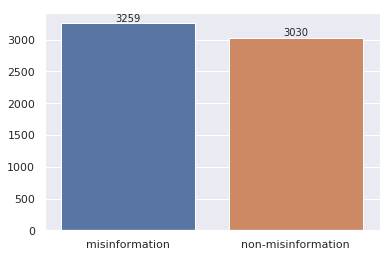

In [32]:
def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')
print('data balance in dataset')        
print_class_balance(y)

# Train-test split

train
test


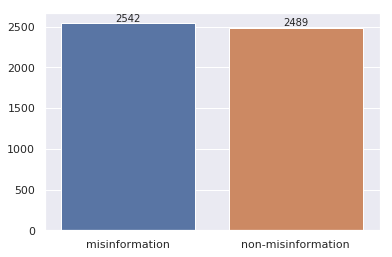

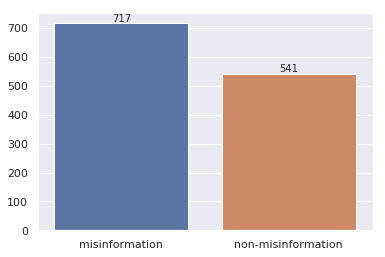

In [33]:
# use only characters
# texts = df['text']
# texts = [' '.join(list(t)) for t in texts]

# train with the 80% older messages; test with the 20% newer
# split by time

X_train_texts = texts[0:cut]
y_train= y[0:cut]
X_test_texts = texts[cut:]
y_test = y[cut:]

X_train_og_texts = original_texts[0:cut]
X_test_og_texts = original_texts[cut:]

corpus = [t.split() for t in corpus if t not in X_test_texts and type(t)==str]

print('train')
print_class_balance(y_train)
plt.figure()
print('test')
print_class_balance(y_test)

In [34]:
len(corpus)

99016

In [35]:
print('samples train')
pos_mask = y_train == 1 
mis = X_train_og_texts[pos_mask]
neg_mask = y_train == 0 
non_mis = X_train_og_texts[neg_mask]
sample = list(mis.sample(1))
print()
print('misinformation')
for m in sample:
    print('*********')
    print(m)
    print()
    
sample = list(non_mis.sample(1))
print('---------------------------------------')
print('non misinformation')
for m in sample:
    print('*********')
    print(m)
    print()

samples train

misinformation
*********
Empresário venezuelano recriou sua foto do antes e o depois do socialismo.

---------------------------------------
non misinformation
*********
Cid Gomes é convidado para participar de evento de campanha do PT no 2o turno, que aconteceu nesta segunda à noite (15/10/2018) no Ceará, e descontou a rasteira que Ciro levou de Lula !! Esculachou o PT na cara dos militantes !!!! Confira 👆🏻👆🏻

“Vão perder feio porque fizeram muita besteira, porque aparelharam as repartições públicas...Vão perder a eleição, e é bem feito...”

“Lula o que ? O Lula tá preso, babaca !! O Lula tá preso, e vai fazer o que ?”



In [36]:
print('samples test')
pos_mask = y_test == 1 
mis = X_test_og_texts[pos_mask]
neg_mask = y_test == 0 
non_mis = X_test_og_texts[neg_mask]
sample = list(mis.sample(100))
print()
print('misinformation')
for m in sample:
    print('*********')
    print(m)
    print()
    
# sample = list(non_mis.sample(1))
# print('---------------------------------------')
# print('non misinformation')
# for m in sample:
#     print('*********')
#     print(m)
#     print()

samples test

misinformation
*********
O que cai com a ascensão do Bolsonaro:

1)  Todo o esquema de poder construído pelo PT e seus associados ao longo de cinquenta anos.

2)  O centro motor e financiador de todo o movimento comunista latino-americano. Portanto, o Foro de S. Paulo com as duzentas organizações que o compõem.

3)  Os planos internacionais de eliminação da soberania nacional brasileira e de subgjugação do país ao esquema globalista.

4)  Milhares de carreiras e biografias de politicos, intelectuais e artistas de esquerda.

5)  Todo o poder impune do narcotráfico e do crime organizado em geral.

6)  Todas as grandes empresas de mídia.

7)  Toda a constelação de prestigios do show business.

8)  Todo o sistema de poder instalado nas universidades e no sistema de ensino em geral.
 
A queda de tudo isso é imediata e automática no dia mesmo da posse de Bolsonaro.  Ademais, o famoso “Gigante Adormecido”, o povo brasileiro, acordou e não há soporífero capaz de faze-lo voltar a 

In [12]:
list(zip(X_test_og_texts,y_test))

[('Urgente!!!! Isso saiu da boca de Kátia Abreu, vice de ciro Gomes, sera que ainda precisa fala mais alguma coisa????',
  0),
 ('https://www.facebook.com/100026399202184/posts/185277722362200/\n\nExcelente Idéia !!!\n\nPara evitar fraude na contagem de votos no 2o Turno...\n\nGuarde seu comprovante de voto, escreva 17 nele, fotografe e envie ao email de Bolsonaro !!!\n\ndep.jairbolsonaro@camara.leg.br',
  1),
 ('O desembargador destaca que os procedimentos serão realizados para garantir a lisura do processo de votação eletrônica. http://ricardochudo.blogspot.com/2018/10/desembargador-autoriza-auditoria.html',
  0),
 ('*Resgatamos reportagem da Globo News, que ágora trata o kit gay como fake news, nada como recorda a verdade.*\n\nhttps://m.facebook.com/story.php?story_fbid=304742586786920&id=166486373945876',
  1),
 ('Terminou a apuração dos votos no JAPÃO 😍\n97% Bolsonaro\n1% Haddad\n2% NULOS',
  0),
 ('💚💛💚💛💚💛💚💛💚💛\n\n*ALGUNS FICAM POR AÍ COM CONVERSAS DO TIPO SE ACONTECER ISSO OU AQUI

# BoW

In [37]:
#vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer = CountVectorizer(max_features = None, ngram_range = (1,3), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)
vectorizer.fit(X_train_texts)   
X_train = vectorizer.transform(X_train_texts)
X_test = vectorizer.transform(X_test_texts)
X_train.shape

(5031, 315968)

In [38]:
print(vectorizer.get_feature_names()[100:150])

['! ! estar', '! ! evitar', '! ! exigir', '! ! facam', '! ! falir', '! ! familia', '! ! faomos', '! ! farar', '! ! farlei', '! ! fato', '! ! favor', '! ! fazer', '! ! feliz', '! ! fernando', '! ! ficar', '! ! ficor', '! ! filhar', '! ! fiscal', '! ! focar', '! ! foraaaaaa', '! ! forcar', '! ! fraudar', '! ! froudor', '! ! futurar', '! ! gang', '! ! ganhar', '! ! general', '! ! gente', '! ! gloriar', '! ! gracas', '! ! grande', '! ! grupar', '! ! haddad', '! ! hanna', '! ! hoje', '! ! homem', '! ! homenagem', '! ! incluir', '! ! incrivel', '! ! investir', '! ! ir', '! ! ja', '! ! jipeiros', '! ! jogar', '! ! jovem', '! ! jurista', '! ! kkk', '! ! l', '! ! ler', '! ! luis']


logistic regression + binary bow
0.41
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       541
           1       0.83      0.75      0.79       717

    accuracy                           0.77      1258
   macro avg       0.77      0.78      0.77      1258
weighted avg       0.78      0.77      0.77      1258

AUC:  0.8605145180292708


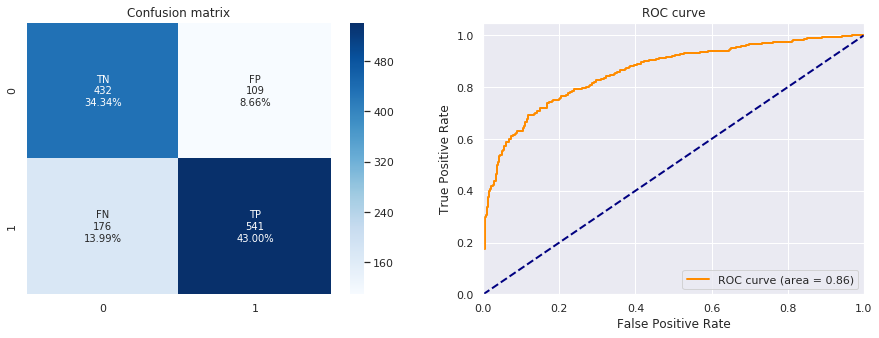

(0.7734499205087441,
 0.8323076923076923,
 0.7519582245430808,
 0.7545327754532776,
 0.7519582245430808,
 0.7915142648134601,
 0.7519582245430808,
 0.8605145180292708)

In [39]:
print('logistic regression + binary bow')
clf = LogisticRegression()
clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

#thr = optimal_threshold(y_prob,y_test)
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + bow
Iteration 1, loss = 0.60547655
Validation score: 0.779762
Iteration 2, loss = 0.45962190
Validation score: 0.827381
Iteration 3, loss = 0.37089550
Validation score: 0.831349
Iteration 4, loss = 0.30443630
Validation score: 0.827381
Iteration 5, loss = 0.25725245
Validation score: 0.833333
Iteration 6, loss = 0.22168191
Validation score: 0.839286
Iteration 7, loss = 0.19360161
Validation score: 0.833333
Iteration 8, loss = 0.17062923
Validation score: 0.835317
Iteration 9, loss = 0.15206353
Validation score: 0.833333
Iteration 10, loss = 0.13608704
Validation score: 0.835317
Validation score did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
0.5
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       541
           1       0.84      0.70      0.76       717

    accuracy                           0.75      1258
   macro avg       0.76      0.76      0.75      1258
weighted avg       0.77      0.75      0.

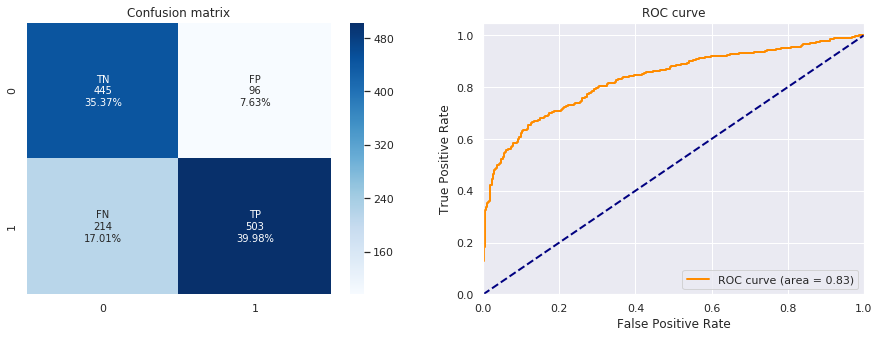

(0.753577106518283,
 0.8397328881469115,
 0.7416666666666667,
 0.701534170153417,
 0.7416666666666667,
 0.7644376899696048,
 0.7416666666666667,
 0.8325689551607771)

In [40]:
print('mlp + bow')
clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 20,
                   hidden_layer_sizes = (100,), alpha = .0001, 
                   learning_rate_init = .0001, batch_size = 200)

clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Topic modelling (LDA)

In [95]:
# # topics
# from gensim.models import LdaModel
# from gensim.corpora.dictionary import Dictionary
# n_topics = 15

# def train_lda(corpus, n_topics = 100):
#     common_texts = [x.split() for x in corpus]
#     common_dictionary = Dictionary(common_texts)
#     common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
#     lda = LdaModel(common_corpus, num_topics=n_topics)
#     return lda, common_dictionary

# lda, common_dictionary = train_lda(X_train_texts, n_topics)

In [96]:
# # vectorizing
# def tup2array(tuples,n_topics):
#     topics = np.zeros(n_topics)
#     for t, p in tuples:
#         topics[t] = p
#     return topics

# def vectorize_topics(X,lda):
#     X = [lda[x] for x in X]
#     X = [tup2array(v,lda.num_topics) for v in X]
#     return X

# def texts2topics(texts,lda):
#     X = [x.split() for x in texts]
#     X = [common_dictionary.doc2bow(text) for text in X]
#     X = vectorize_topics(X,lda)
#     return X
    

# X_train_topics = texts2topics(X_train_texts,lda)
# X_test_topics = texts2topics(X_test_texts,lda)

In [41]:
# print('logistic regression + lda')
# clf = LogisticRegression()
# clf.fit(X_train_topics,y_train)
# y_prob = clf.predict_proba(X_test_topics)[:,1]
# y_prob_train = clf.predict_proba(X_train_topics)[:,1]
# thr = optimal_threshold(y_prob_train,y_train)
# print(thr)
# y_pred = [1 if p >= thr else 0 for p in y_prob]
# test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

In [42]:
# print('mlp + lda')
# # clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
# #                    tol = 1e-3, verbose = True, early_stopping = True, 
# #                    n_iter_no_change = 3, max_iter = 100,
# #                    hidden_layer_sizes = (100,), alpha = .00001, 
# #                    learning_rate_init = .0001, batch_size = 32)
# # hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# # clf = optimized_mlp(hl,bs,al,lri)

# # results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)
# clf.fit(X_train_topics,y_train)
# y_prob = clf.predict_proba(X_test_topics)[:,1]
# y_prob_train = clf.predict_proba(X_train_topics)[:,1]
# thr = optimal_threshold(y_prob_train,y_train)
# print(thr)
# y_pred = [1 if p >= thr else 0 for p in y_prob]
# test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Contextual features
* How many times the message was shared
* How many people have seen it
* How many groups
* Features from users that shared the message / credibility
* Spreading velocity

Not a good approach for this dataset

# Word embeddings

In [48]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

In [49]:
len(corpus)

99016

In [52]:
class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        self.epoch += 1
        print("W2V: Epoch #{}".format(self.epoch))
        
epoch_logger = EpochLogger()

w2v = Word2Vec(min_count=1)
w2v.build_vocab(corpus)  # prepare the model vocabulary
w2v.train(corpus, total_examples=w2v.corpus_count, 
            epochs=15, compute_loss=True, 
            callbacks=[epoch_logger])

w2v.save("data/2018/word2vec_train.model")

w2v = Word2Vec.load("data/2018/word2vec_train.model")

W2V: Epoch #1
W2V: Epoch #2
W2V: Epoch #3
W2V: Epoch #4
W2V: Epoch #5
W2V: Epoch #6
W2V: Epoch #7
W2V: Epoch #8
W2V: Epoch #9
W2V: Epoch #10
W2V: Epoch #11
W2V: Epoch #12
W2V: Epoch #13
W2V: Epoch #14
W2V: Epoch #15


In [53]:
w2v.most_similar(positive=['deus'])

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('dars', 0.7139336466789246),
 ('senhor', 0.6260266304016113),
 ('vosso', 0.6106389760971069),
 ('ti', 0.5856348872184753),
 ('oracao', 0.5833683609962463),
 ('paz', 0.5663832426071167),
 ('amar', 0.5575193166732788),
 ('orar', 0.5557647943496704),
 ('coracao', 0.5531859397888184),
 ('salvacao', 0.5515108704566956)]

In [54]:
def vectorize_text(model, text, method='mean'):
        """
        Convert all words in a text to their embedding vector
        and calculate a vector for the text, by the mean or the sum of word vectors
        Parameters
        ----------
        text: str
        Text from wich the word vector's will be calculated    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        vec: numpy.ndarray 
        Array of the word embeddings from the given text 
        """
        n = model.vector_size
        X = np.empty(shape=[0, n])
        words = text.split()
        for word in words:
            try:
                vec = model[word]
                X = np.append(X,[vec], axis = 0)
            # if oov:    
            except:
                #print('word not in vocabulary: ', word)
                continue
        if X.size == 0:
            vec = np.zeros(n)
        elif method == 'mean':
            vec = np.mean(X,axis=0)
        elif method == 'sum':
            vec = np.sum(X,axis=0)
        return vec
    
def vectorize_corpus(model, corpus, method='mean'):
        """
        Convert all texts in a corpus to vectors
        Parameters
        ----------
        corpus: list
        List of texts    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        X: numpy.ndarray 
        2D Array of vectors from each text in corpus
        """
        X = [vectorize_text(model, text, method=method) for text in corpus]
        X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
        return X

x = vectorize_corpus(w2v, 'bolsonaro é um prego')
x

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


array([[ 3.25345612,  1.6707257 , -1.90183985, ..., -0.94146472,
         0.94105381,  2.88164473],
       [-0.2277987 , -0.43457711, -0.61379606, ..., -0.58506846,
         2.90742946, -0.28173509],
       [ 0.12325625,  2.33133435,  0.48778793, ..., -0.3142539 ,
         1.54634809,  0.67772835],
       ...,
       [ 0.14176123, -0.25785565,  0.32586467, ...,  0.15061983,
        -0.12593842, -0.21586418],
       [ 1.49835074,  1.77884007,  0.72895592, ...,  0.63206869,
         3.40126681, -0.21702349],
       [-0.2277987 , -0.43457711, -0.61379606, ..., -0.58506846,
         2.90742946, -0.28173509]])

In [55]:
X_train = vectorize_corpus(w2v,X_train_texts)
X_test = vectorize_corpus(w2v,X_test_texts)

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


logistic regression + w2v
0.53
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       541
           1       0.73      0.68      0.70       717

    accuracy                           0.67      1258
   macro avg       0.67      0.67      0.67      1258
weighted avg       0.68      0.67      0.67      1258

AUC:  0.7209207598924458


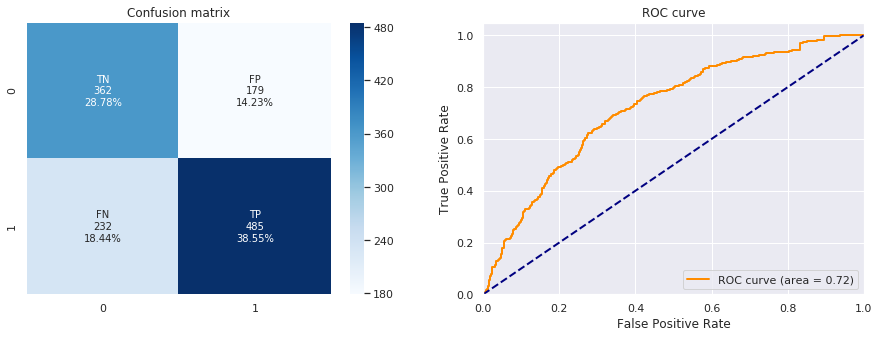

In [56]:
print('logistic regression + w2v')
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.859
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.863
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.862
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.892
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.855
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.853
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.864
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.850
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.868
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.874
10 
hidden layers: (75, 300, 25); alpha: 0.00002; learning rate: 0.0012

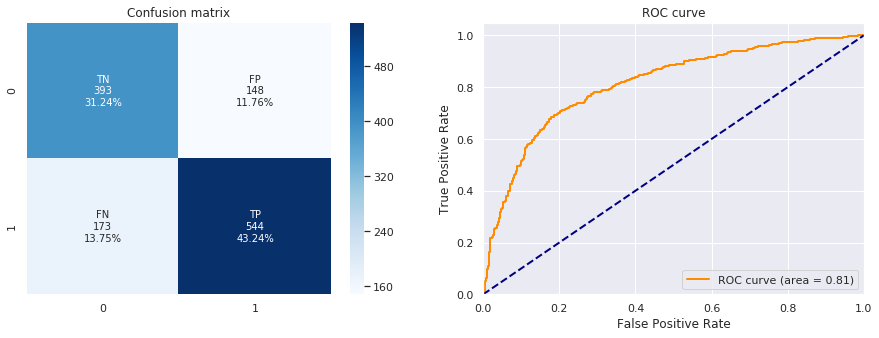

In [57]:
print('mlp + w2v')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=20)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Doc2Vec

In [58]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
model.save('data/2018/doc2vec.model')

doc2vec = Word2Vec.load("data/2018/doc2vec.model")

In [59]:
doc2vec.infer_vector(['bolsonaro','meu','ovo'])

array([ 0.0257614 , -0.02007688,  0.02418337,  0.0164551 , -0.03250744,
       -0.00646064,  0.05152241,  0.01068196,  0.04287212, -0.00445374,
       -0.02219662, -0.02679642,  0.00759478,  0.01108558,  0.03277311,
        0.01910946,  0.01695978,  0.05702525,  0.0234786 ,  0.02547294,
       -0.00196291,  0.0089161 ,  0.00255432,  0.00859911, -0.03411416,
        0.0128093 , -0.0254628 , -0.00668913,  0.02657778, -0.00663523,
       -0.01544485,  0.06473401, -0.03442589,  0.02446764,  0.00754626,
       -0.02721661,  0.00293685,  0.00852335,  0.0042542 ,  0.01193599,
        0.03948187,  0.00877202, -0.00303579,  0.01816785,  0.00063821,
       -0.03288557,  0.00566494,  0.03054626, -0.02427696,  0.06096199,
        0.01641613, -0.00579324, -0.00310605, -0.00608708, -0.01471881,
       -0.0037299 ,  0.01110814,  0.02501493, -0.02619533,  0.02750329,
        0.05060125,  0.03222952, -0.00193815, -0.01715562, -0.04523791,
        0.00534652, -0.01574357,  0.03695276,  0.0241667 , -0.03

In [60]:
def vectorize_doc2vec(model,text):
    text = text.split()
    vector = model.infer_vector(text)
    return vector

def vectorize_corpus_doc2vec(model,corpus):
    X = [vectorize_doc2vec(model, text) for text in corpus]
    X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
    return X

X_train = vectorize_corpus_doc2vec(doc2vec, X_train_texts)
X_test = vectorize_corpus_doc2vec(doc2vec, X_test_texts)

logistic regression + doc2vec
              precision    recall  f1-score   support

           0       0.58      0.74      0.65       541
           1       0.75      0.61      0.67       717

    accuracy                           0.66      1258
   macro avg       0.67      0.67      0.66      1258
weighted avg       0.68      0.66      0.66      1258

AUC:  0.7318308726285587


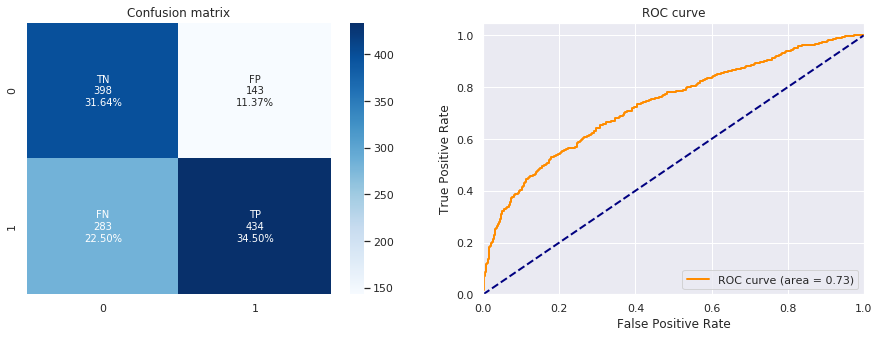

(0.6613672496025437,
 0.7521663778162911,
 0.6513911620294598,
 0.6052998605299861,
 0.6513911620294598,
 0.6707882534775889,
 0.6513911620294598,
 0.7318308726285587)

In [61]:
print('logistic regression + doc2vec')
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + doc2vec
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.848
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.817
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.829
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.803
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.846
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.821
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.846
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.847
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.852
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.850
10 
hidden layers: (75, 300, 25); alpha: 0.00002; learning rate: 0.

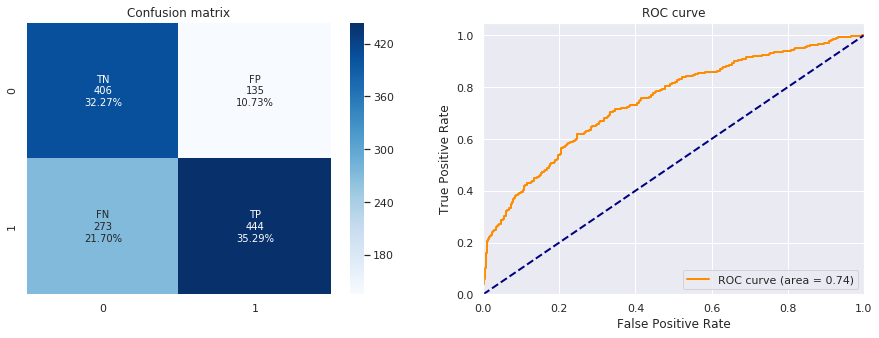

In [62]:
print('mlp + doc2vec')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=50)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)